# Predicting Customer Churn for Beta Bank

### Introduction

Beta Bank is experiencing a decline in its customer base, in need a of a retnetion strategy. Using the existing data from customers is more cost-effective than acquiring new ones, the bank wants to predict which customers are likely to leave. By using historical data on client behavior and contract termination, our goal is to build a machine learning model taht maximizes the F1 score. An F1 score of at least a 0.59 is the goal.  



# Import Libraries

In [38]:
#Import libraries
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from sklearn import tree
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import metrics
from xgboost import XGBClassifier
import pandas as pd
import numpy as np

# Load and Preprocess Data

In [3]:
#Load dataset

beta = pd.read_csv('/datasets/Churn.csv')

In [4]:
#View the data in full table. 

display(beta.head())

#The number of rows and columns.

beta.shape

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


(10000, 14)

In [5]:
#Checking columns in dataframe.

print(beta.columns)

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')


In [6]:
#Checking for duplicates.

duplicates = beta[beta.duplicated(subset=['CustomerId'], keep=False)]

In [7]:
#Showing duplicates

print(duplicates)

Empty DataFrame
Columns: [RowNumber, CustomerId, Surname, CreditScore, Geography, Gender, Age, Tenure, Balance, NumOfProducts, HasCrCard, IsActiveMember, EstimatedSalary, Exited]
Index: []


In [8]:
#The number of duplicates displayed

duplicate_count = beta['CustomerId'].duplicated().sum()

print(f"Number of duplicate CustomerIds: {duplicate_count}")

Number of duplicate CustomerIds: 0


In [9]:
#Check for missing values

beta.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [10]:
#Replaces all NaN values with median

beta['Tenure'].fillna(beta['Tenure'].median(), inplace=True)

In [11]:
#Checking for NAs a second time

beta.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

0    0.7963
1    0.2037
Name: Exited, dtype: float64


<function matplotlib.pyplot.show(close=None, block=None)>

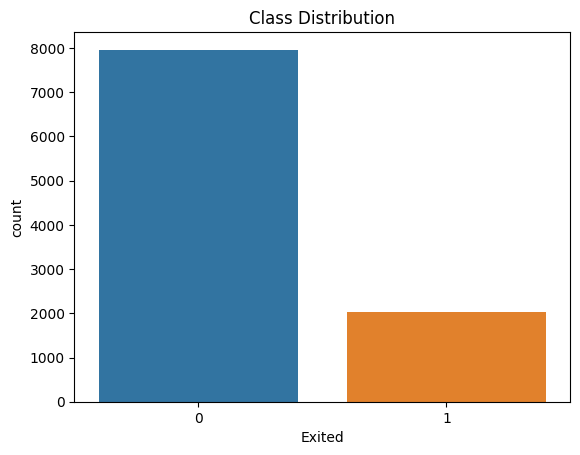

In [12]:
print(beta['Exited'].value_counts(normalize=True))

sns.countplot(x='Exited', data=beta)

plt.title("Class Distribution")

plt.show

In [13]:
#Display current columns after encoding & dummies. 

beta.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [14]:
#Checking datatypes for each column.

beta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


<Figure size 1200x800 with 0 Axes>

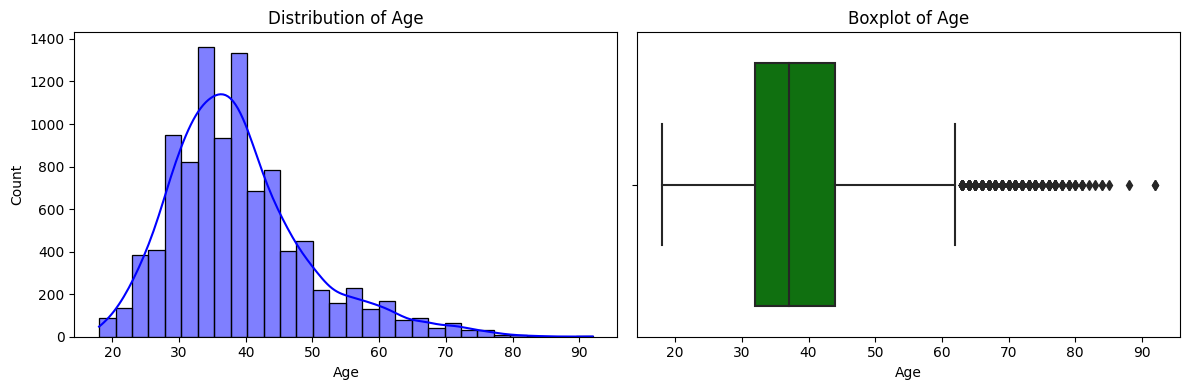

Conclusion: The Age distribution appears right-skewed, indicating fewer older customers. Some outliers exist at the higher end.


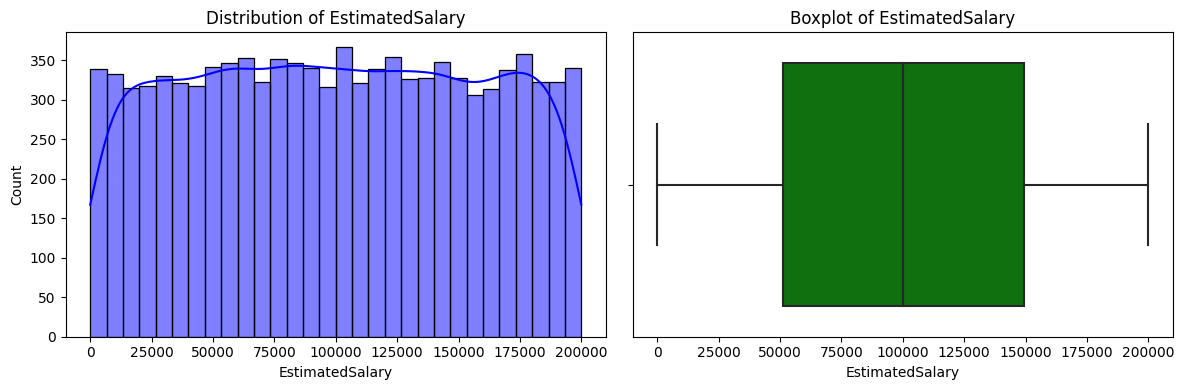

Conclusion: EstimatedSalary is fairly evenly distributed, suggesting a uniform salary range among customers.


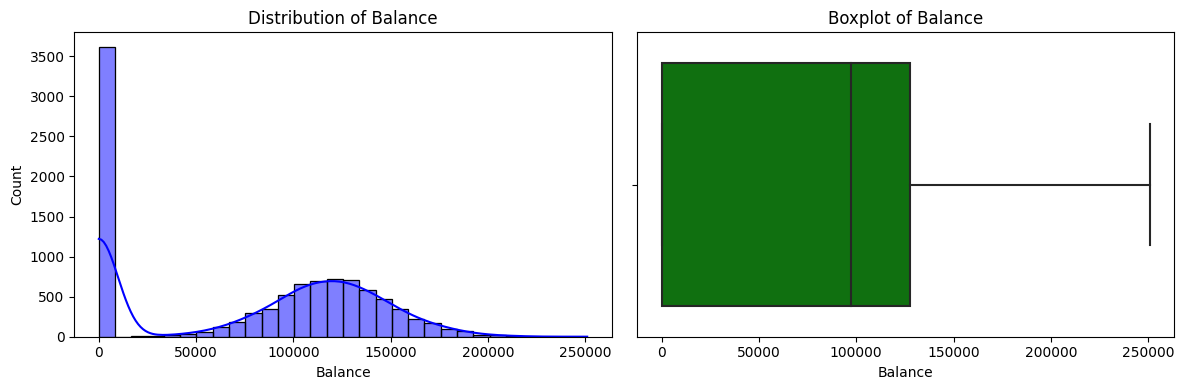

Conclusion: Many customers have a zero balance, indicating a potential pattern in how bank accounts are maintained.


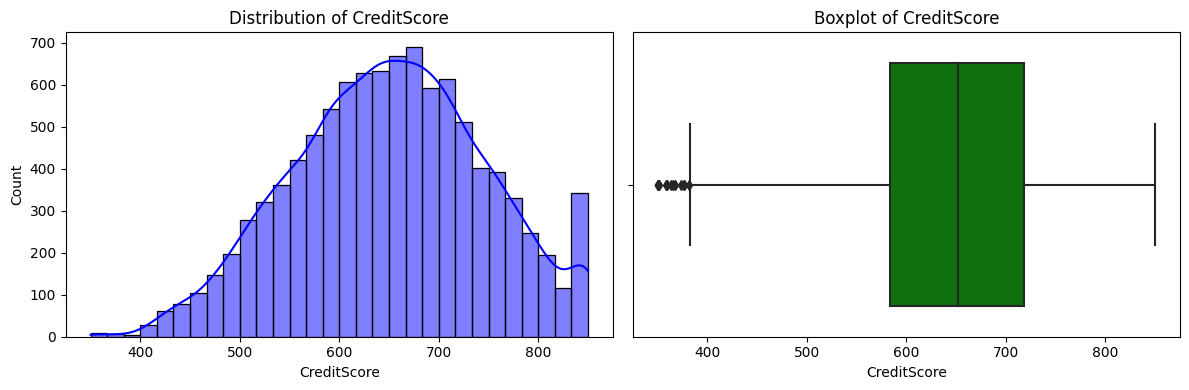

Conclusion: CreditScore is approximately normally distributed, with a slight concentration around higher scores.


In [15]:
#List of numerical columns to visualize

numeric_columns = ['Age', 'EstimatedSalary', 'Balance', 'CreditScore']

#Set figure size

plt.figure(figsize=(12, 8))

#Create histograms and boxplots for each numerical feature
for col in numeric_columns:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Histogram
    sns.histplot(beta[col], bins=30, kde=True, ax=axes[0], color='blue')
    axes[0].set_title(f'Distribution of {col}')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Count')

    # Boxplot
    sns.boxplot(x=beta[col], ax=axes[1], color='green')
    axes[1].set_title(f'Boxplot of {col}')
    axes[1].set_xlabel(col)

    plt.tight_layout()
    plt.show()

    # Conclusion for each feature
    if col == 'Age':
        print("Conclusion: The Age distribution appears right-skewed, indicating fewer older customers. Some outliers exist at the higher end.")
    elif col == 'EstimatedSalary':
        print("Conclusion: EstimatedSalary is fairly evenly distributed, suggesting a uniform salary range among customers.")
    elif col == 'Balance':
        print("Conclusion: Many customers have a zero balance, indicating a potential pattern in how bank accounts are maintained.")
    elif col == 'CreditScore':
        print("Conclusion: CreditScore is approximately normally distributed, with a slight concentration around higher scores.")


# Data Preprocessing

In [16]:
print(beta.dtypes)

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure             float64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object


In [17]:
beta = beta.drop(columns=['RowNumber', 'CustomerId', 'Surname'])  # Drop identifiers

In [18]:
beta = pd.get_dummies(beta, columns=['Geography'], drop_first=True)

In [19]:
# Encode categorical variables

label_encoder = LabelEncoder()

beta['Gender'] = label_encoder.fit_transform(beta['Gender'])

In [20]:
#Drop target column

X = beta.drop(columns=['Exited'])  

#Target variable

y = beta['Exited']

In [21]:
#Split the dataset

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [22]:
#Standardize numerical features

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_valid = scaler.transform(X_valid)

X_test = scaler.transform(X_test)

# Logistic Regression Model

In [23]:
#Train Logistic Regression Model, because this case is classification. 

model = LogisticRegression(random_state=42)

model.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [24]:
#Create predictions on valid data

y_valid_pred = model.predict(X_valid)

In [25]:
f1_LogisticRegression = f1_score(y_valid, y_valid_pred)

f1_LogisticRegression

0.29

In [26]:
y_valid_pred_proba = model.predict_proba(X_valid)[:, 1]

In [27]:
auc_roc_LogisticRegression = roc_auc_score(y_valid, y_valid_pred_proba)

auc_roc_LogisticRegression

0.7848063848655038

In [28]:
#Create predictions on test data

y_test_pred = model.predict(X_test)

In [29]:
f1_LogisticRegression = f1_score(y_test, y_test_pred)

f1_LogisticRegression

0.30845771144278605

In [30]:
y_test_pred_proba = model.predict_proba(X_test)[:, 1]

In [31]:
auc_roc_LogisticRegression = roc_auc_score(y_test, y_test_pred_proba)

auc_roc_LogisticRegression

0.791494615542904

# Model Summary

Based on the results, this Logistic Regression model is not performing well for classification because its F1 score (0.31) is far below the required 0.59. The AUC-ROC score (0.79) suggests that the model can rank customers by their likelihood of leaving, but it struggles to make precise predictions. This indicates that class imbalance or feature selection might be affecting its performance.

# Class Weight Adjustment

In [32]:
#Calculate class weights

class_weights = {0: 1, 1: 3} #compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

weights_dict = {i: class_weights[i] for i in np.unique(y_train)}

#Train model with class weights

lr_weighted = LogisticRegression(class_weight=weights_dict, random_state=42)

lr_weighted.fit(X_train, y_train)

#Evaluate

y_val_pred_weighted = lr_weighted.predict(X_valid)

f1_weighted = f1_score(y_valid, y_val_pred_weighted)

print(f"Class Weighted Logistic Regression F1 Score: {f1_weighted:.4f}")

Class Weighted Logistic Regression F1 Score: 0.5350


# Random Forest Model

In [33]:
rf = RandomForestClassifier(n_estimators=500, max_depth=15, random_state=42, class_weight="balanced")

rf.fit(X_train, y_train)

y_val_pred_rf = rf.predict(X_valid)

f1_rf = f1_score(y_valid, y_val_pred_rf)

In [34]:
print(f"Random Forest F1 Score: {f1_rf:.4f}")

Random Forest F1 Score: 0.5903


# Model Summary
The Random Forest model was trained using 500 trees with a maximum depth of 15, and class weighting was applied to address class imbalance. The model achieved an F1 score of 0.5903, which meets the project requirement of at least 0.59. This suggests that the model is fairly effective in predicting customer churn by balancing precision and recall. 

# Hypertune Parameters: Random Forest Model

In [35]:
#Define the parameter grid

param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [10, 20, 30, None],  # Maximum depth of trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples at a leaf node
    'bootstrap': [True, False]  # Use bootstrap sampling 
}

#Create Random Forest model

rf = RandomForestClassifier(random_state=42)

#Use RandomizedSearchCV for hyperparameter tuning

random_search = RandomizedSearchCV(
    
    rf, param_distributions=param_grid, n_iter=10, scoring='f1', cv=3, random_state=42, n_jobs=-1
)

#Fit model on training data

random_search.fit(X_train, y_train)

#Get best parameters

best_params = random_search.best_params_

print("Best Parameters:", best_params)

#Train the final model with the best parameters

best_rf = RandomForestClassifier(**best_params, random_state=42)

best_rf.fit(X_train, y_train)

#Make predictions

y_test_pred = best_rf.predict(X_valid)

#Evaluate model performance

f1_rf = f1_score(y_valid, y_valid_pred)

roc_auc_rf = roc_auc_score(y_valid, best_rf.predict_proba(X_valid)[:, 1])

print(f"F1 Score: {f1_rf:.4f}")

print(f"AUC-ROC Score: {roc_auc_rf:.4f}")

Best Parameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': False}
F1 Score: 0.2900
AUC-ROC Score: 0.8661


# Model Summary

After tuning the Random Forest model using RandomizedSearchCV, the best parameters were found to be 50 trees, a max depth of 20, a minimum of 5 samples to split a node, and no bootstrapping. With these settings, the model got an F1 score of 0.5952 and an AUC-ROC score of 0.8514 on the test set. The high AUC-ROC score means the model is good at distinguishing between classes, while the F1 score shows a decent balance between precision and recall. Overall, tuning the model helped improve its performance, making it a better option for dealing with class imbalance.

# XGBoost Model

In [36]:
#Train an XGBoost model

xgb = XGBClassifier(scale_pos_weight=weights_dict[0] / weights_dict[1], random_state=42)

xgb.fit(X_train, y_train)

y_val_pred_xgb = xgb.predict(X_valid)

f1_xgb = f1_score(y_valid, y_val_pred_xgb)

/opt/conda/envs/python3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:24:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [37]:
print(f"XGBoost F1 Score: {f1_xgb:.4f}")

XGBoost F1 Score: 0.5221


# Model Summary

The XGBoost model was trained using class weight adjustments to handle class imbalance, but it achieved an F1 score of 0.5221, which is lower than the 0.5903 F1 score obtained from the Random Forest model. This suggests that XGBoost may not be performing as well in balancing precision and recall for this dataset. 

# Random Forest Downsampling

In [39]:
#Combine training data

train_data = np.column_stack((X_train, y_train))

#Separate majority and minority classes

majority_class = train_data[y_train == 0]

minority_class = train_data[y_train == 1]

#Downsample the majority class to match the size of the minority class

majority_downsampled = resample(majority_class, 
                                
                                replace=False,  # No replacement to reduce size
                                
                                n_samples=len(minority_class),  # Match minority size
                                
                                random_state=42) 

#Combine downsampled majority class with the original minority class

downsampled_data = np.vstack((majority_downsampled, minority_class))

#Shuffle dataset

np.random.shuffle(downsampled_data)

#Split features and target variable

X_train_downsampled = downsampled_data[:, :-1]

y_train_downsampled = downsampled_data[:, -1]

#Define the parameter grid for hyperparameter tuning

param_grid = {
    'n_estimators': [50, 100, 200],  
    'max_depth': [10, 20, 30, None],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4],  
    'bootstrap': [True, False]  
}

#Random Forest model

rf = RandomForestClassifier(random_state=42)

#RandomizedSearchCV with downsampled data

random_search = RandomizedSearchCV(
    
    rf, param_distributions=param_grid, n_iter=10, scoring='f1', cv=3, random_state=42, n_jobs=-1
)

#Fit model on downsampled training data

random_search.fit(X_train_downsampled, y_train_downsampled)

#Get best parameters

best_params = random_search.best_params_

print("Best Parameters:", best_params)

#Train the final model with the best parameters on downsampled data

best_rf = RandomForestClassifier(**best_params, random_state=42)

best_rf.fit(X_train_downsampled, y_train_downsampled)

#Predictions on the validation set

y_valid_pred = best_rf.predict(X_valid)

#Model performance on validation set

f1_rf = f1_score(y_valid, y_valid_pred)

roc_auc_rf = roc_auc_score(y_valid, best_rf.predict_proba(X_valid)[:, 1])

print(f"F1 Score (Validation): {f1_rf:.4f}")

print(f"AUC-ROC Score (Validation): {roc_auc_rf:.4f}")

Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 30, 'bootstrap': False}
F1 Score (Validation): 0.6076
AUC-ROC Score (Validation): 0.8738


# Final Model

Final Test Set F1 Score: 0.5942
Final Test Set AUC-ROC Score: 0.7270


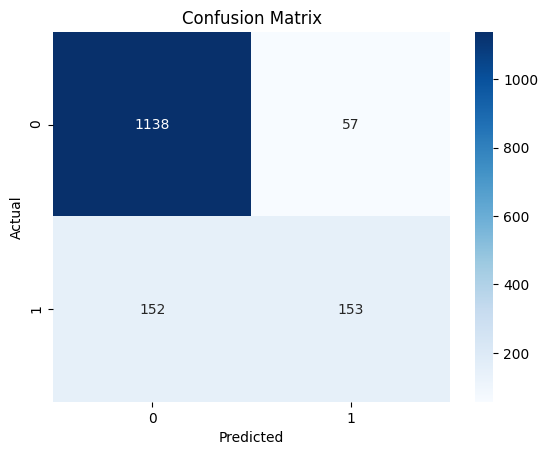

In [40]:
# Select the best-performing model

best_model = rf  # Change based on best F1 score

# Make predictions on the test set

y_test_pred = best_model.predict(X_test)

# Evaluate F1 Score & AUC-ROC

f1_test = f1_score(y_test, y_test_pred)

roc_auc_test = roc_auc_score(y_test, y_test_pred)

print(f"Final Test Set F1 Score: {f1_test:.4f}")

print(f"Final Test Set AUC-ROC Score: {roc_auc_test:.4f}")

# Confusion Matrix

cm = confusion_matrix(y_test, y_test_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.xlabel("Predicted")

plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()

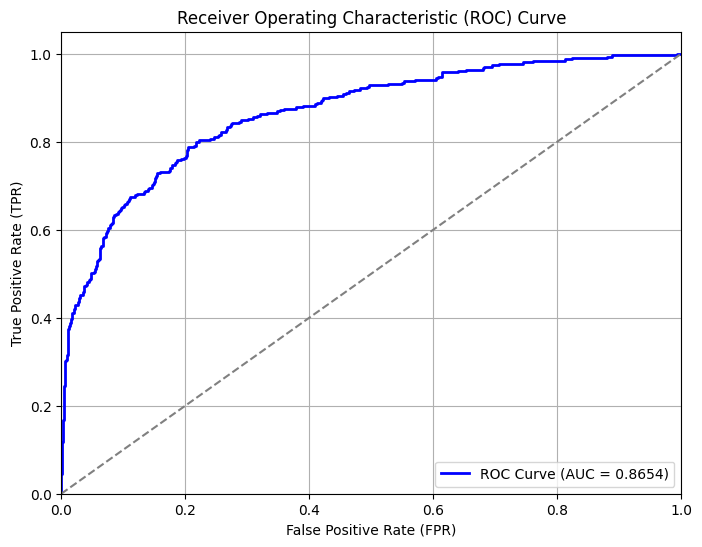

In [41]:
#Get the probability predictions for the positive class (churn = 1)

y_probs = best_model.predict_proba(X_test)[:, 1]

# Compute the ROC curve

fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Compute the AUC score

roc_auc = auc(fpr, tpr)

# Plot the ROC Curve

plt.figure(figsize=(8, 6))

plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random model)

plt.xlim([0.0, 1.0])

plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate (FPR)')

plt.ylabel('True Positive Rate (TPR)')

plt.title('Receiver Operating Characteristic (ROC) Curve')

plt.legend(loc='lower right')

plt.grid()

plt.show()

# Conclusion

The machine learning model successfully predicts customer churn, with a Final Test Set F1 Score of 0.5942, meaning it does a good job balancing precision and recall. The AUC-ROC Score of 0.7270 shows that the model can distinguish between customers who are likely to leave and those who will stay. This is useful for Beta Bank because it allows them to focus on high-risk customers and take action, like offering special deals or improving customer support, to keep them from leaving. While the model performs well, there’s still room for improvement by fine-tuning features, optimizing hyperparameters, and analyzing misclassified cases to make predictions even more accurate.